<a href="https://colab.research.google.com/github/Siddharth-Prajapatii/Sepsis-Detection-Using-Machine-Learning/blob/master/Sepsis_Detection_Using_Physiological_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sepsis Detection Using Physiological Data**

> ### **Non-Temporal Approach**






### **Libraries To Be Imported**

In [0]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### **Unzipping The Data Files**

In [13]:
uploaded = files.upload()
!unzip training_setA.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/p015338.psv    
  inflating: training/p015339.psv    
  inflating: training/p015340.psv    
  inflating: training/p015341.psv    
  inflating: training/p015342.psv    
  inflating: training/p015343.psv    
  inflating: training/p015344.psv    
  inflating: training/p015345.psv    
  inflating: training/p015346.psv    
  inflating: training/p015347.psv    
  inflating: training/p015348.psv    
  inflating: training/p015349.psv    
  inflating: training/p015350.psv    
  inflating: training/p015351.psv    
  inflating: training/p015352.psv    
  inflating: training/p015353.psv    
  inflating: training/p015354.psv    
  inflating: training/p015355.psv    
  inflating: training/p015356.psv    
  inflating: training/p015357.psv    
  inflating: training/p015358.psv    
  inflating: training/p015359.psv    
  inflating: training/p015360.psv    
  inflating: training/p015361.psv    
  inflating: training/p015362.psv    

### **Concating All PSV File Data Into Dataset Variable**

In [16]:
path =r'training'
filenames = glob.glob(path + "/*.psv")

#Temporary Data Frame
df= []

for filename in filenames:
    df.append(pd.read_csv(filename,sep='|',index_col=None))
Dataset = pd.concat(df,axis=0,ignore_index=True)

Dataset.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,90.0,100.0,36.44,158.0,106.0,77.0,13.5,NaN,-2.0,22.0,NaN,7.30,47.0,87.0,673.0,23.0,97.0,NaN,104.0,NaN,NaN,189.0,6.3,NaN,NaN,4.4,NaN,NaN,29.9,10.4,NaN,9.0,NaN,NaN,53.38,1,NaN,NaN,-155.26,2,0
1,93.5,100.0,NaN,153.0,97.5,71.5,18.0,NaN,-2.0,NaN,0.6,7.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.38,1,NaN,NaN,-155.26,3,0
2,92.0,100.0,NaN,149.0,94.0,68.0,18.0,NaN,-2.0,NaN,0.6,7.33,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.38,1,NaN,NaN,-155.26,4,0
3,89.5,100.0,NaN,138.0,90.0,66.5,18.0,NaN,-2.0,NaN,0.6,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.38,1,NaN,NaN,-155.26,5,0
4,90.0,100.0,NaN,137.0,91.0,70.0,18.0,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.38,1,NaN,NaN,-155.26,6,0


### **Visualize Missing Values In Dataset & Feature Engineering**

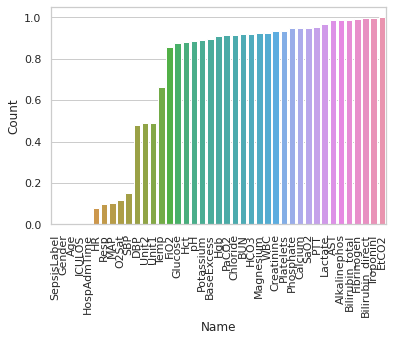

In [17]:
missing_values = Dataset.isnull().sum() / len(Dataset)


#Feature Engineering
feature_engineered_attributes= missing_values[missing_values <= 0.8]
feature_engineered_attributes_arr=[]
feature_engineered_attributes_arr=feature_engineered_attributes.index
Drop_attributes=[]

for x in Dataset:
        if x not in feature_engineered_attributes_arr:
            Drop_attributes.append(x)
Dataset=Dataset.drop(columns=Drop_attributes)

missing_values.sort_values(inplace=True)
missing_values

missing_values = missing_values.to_frame()
missing_values.columns = ['Count']
missing_values.index.names = ['Name']
missing_values['Name'] = missing_values.index


sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'Count', data=missing_values)
plt.xticks(rotation = 90)
plt.show()


### **Visualize Missing Values In Dataset After Feature Engineering**

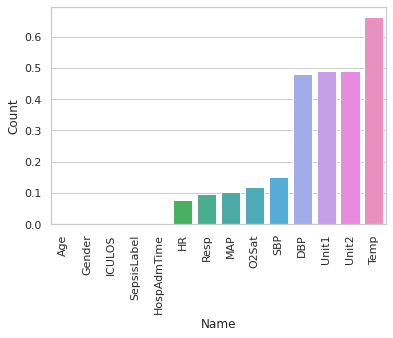

In [18]:
missing_values = Dataset.isnull().sum() / len(Dataset)
missing_values.sort_values(inplace=True)
missing_values

missing_values = missing_values.to_frame()
missing_values.columns = ['Count']
missing_values.index.names = ['Name']
missing_values['Name'] = missing_values.index


sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'Count', data=missing_values)
plt.xticks(rotation = 90)
plt.show()

### **Categorical Encoding**

In [0]:
#Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. Creating a new feature custom_hr , which is categorical variable having three values Normal, Abnormal and Missing
def feature_engineer_hr(Dataset):
    Dataset.loc[(Dataset['HR'] >= 100) & (Dataset['Age'] >= 10 ),
            'custom_HR'] = 'Abnormal'
    Dataset.loc[(Dataset['HR'] < 100) & (Dataset['HR'] > 60) & (Dataset['Age'] >= 10 ),
            'custom_HR'] = 'Normal'
    Dataset.loc[(Dataset['HR'] >= 70) & (Dataset['HR'] < 190) & (Dataset['Age'] < 10 ),
            'custom_HR'] = 'Normal'
    Dataset.loc[((Dataset['HR'] < 70) | (Dataset['HR'] >= 190)) & (Dataset['Age'] < 10 ),
            'custom_HR'] = 'Abnormal'
    Dataset['custom_HR'].fillna('Missing', inplace=True)
    return Dataset

Dataset=feature_engineer_hr(Dataset)
Dataset=Dataset.drop(columns='HR')

#Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C. Creating a new feature custom_temp , which is categorical variable having three values Normal, Abnormal and Missing
def feature_engineer_temp(Dataset):
    Dataset.loc[(Dataset['Temp'] >= 36.4) & (Dataset['Temp'] < 37.6), 
            'custom_TEMP'] = 'Normal'
    Dataset.loc[(Dataset['Temp'] < 36.4) | (Dataset['Temp'] >= 37.6), 
            'custom_TEMP'] = 'Abnormal'

    Dataset['custom_TEMP'].fillna('Missing', inplace=True)
    return Dataset

Dataset=feature_engineer_temp(Dataset)
Dataset=Dataset.drop(columns='Temp')


#Age-Categorizing patient based on age to old, infant and Child/adult
def feature_engineer_age(Dataset):
    Dataset.loc[Dataset['Age'] >=65, 'custom_AGE'] = 'Old'
    Dataset.loc[Dataset['Age'] <1, 'custom_AGE'] = 'Infant'
    Dataset.loc[(Dataset['Age'] >=1) & (Dataset['Age'] <65), 
            'custom_AGE'] = 'Child/Adult'
    return Dataset
Dataset=feature_engineer_age(Dataset)


#O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing
def feature_engineer_o2stat(Dataset):
    Dataset.loc[(Dataset['O2Sat'] >= 90) & (Dataset['O2Sat'] < 100), 
            'custom_O2STAT'] = 'Normal'
    Dataset.loc[(Dataset['O2Sat'] < 90) & (Dataset['O2Sat'] >= 0), 
            'custom_O2STAT'] = 'Abnormal'

    Dataset['custom_O2STAT'].fillna('Missing', inplace=True)
    return Dataset
Dataset=feature_engineer_o2stat(Dataset)
Dataset=Dataset.drop(columns='O2Sat')


#SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure. DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure. Using both these columns to categorize blood pressure as low, normal, elevated , high and missing
def feature_engineer_blood_pressure(Dataset):
    Dataset.loc[(Dataset['SBP'] <90) & (Dataset['DBP'] <60), 'custom_BP'] = 'low'

    Dataset.loc[(Dataset['SBP'].between(90,120, inclusive=True)) & 
            (Dataset['DBP'].between(60,80, inclusive=True)), 
            'custom_BP'] = 'Normal'


    Dataset.loc[(Dataset['SBP'].between(120,140, inclusive=True)) & 
            (Dataset['DBP'].between(80,90, inclusive=True)), 
            'custom_BP'] = 'Elevated'


    Dataset.loc[(Dataset['SBP'] > 140 ) & 
            (Dataset['DBP'] > 90 ), 'custom_BP'] = 'High'

    Dataset['custom_BP'].fillna('Missing', inplace=True)
    return Dataset
Dataset=feature_engineer_blood_pressure(Dataset)
Dataset=Dataset.drop(columns='DBP')
Dataset=Dataset.drop(columns='SBP')


#Respiration rate for healthy adults is between 12 and 20. Categorizing respiratory rate as normal and abnormal based on thresholds.
def feature_engineer_resp_rate(Dataset):
    Dataset.loc[(Dataset['Resp'].between(30,60)) & (Dataset['Age'] <1), 
            'custom_RESP'] = 'Normal'
    Dataset.loc[((Dataset['Resp'] < 30) | (Dataset['Resp'] > 60)) & 
             (Dataset['Age'] <1) ,'custom_RESP'] = 'Abnormal'


    Dataset.loc[(Dataset['Resp'].between(24,40)) & (Dataset['Age'].between(1,3)), 
            'custom_RESP'] = 'Normal'
    Dataset.loc[((Dataset['Resp'] < 24) | (Dataset['Resp'] > 40)) & 
             (Dataset['Age'].between(1,3)) ,'custom_RESP'] = 'Abnormal'


    Dataset.loc[(Dataset['Resp'].between(22,34)) & (Dataset['Age'].between(3,6)), 
            'custom_RESP'] = 'Normal'
    Dataset.loc[((Dataset['Resp'] < 22) | (Dataset['Resp'] > 34)) & 
             (Dataset['Age'].between(3,6)) ,'custom_RESP'] = 'Abnormal'


    Dataset.loc[(Dataset['Resp'].between(18,30)) & (Dataset['Age'].between(6,12)), 
            'custom_RESP'] = 'Normal'
    Dataset.loc[((Dataset['Resp'] < 18) | (Dataset['Resp'] > 30)) & 
             (Dataset['Age'].between(6,12)) ,'custom_RESP'] = 'Abnormal'


    Dataset.loc[(Dataset['Resp'].between(12,20)) & (Dataset['Age'] >12), 
            'custom_RESP'] = 'Normal'
    Dataset.loc[((Dataset['Resp'] < 12) | (Dataset['Resp'] > 20)) & (Dataset['Age'] >12),
            'custom_RESP'] = 'Abnormal'

    Dataset['custom_RESP'].fillna('Missing', inplace=True)

    return Dataset
Dataset=feature_engineer_resp_rate(Dataset)
Dataset=Dataset.drop(columns='Resp')
Dataset=Dataset.drop(columns='Age') #We Are Going To Drop Attribute Age Here Because In Respiration Rate , Age Is Required.



### **Visualize Missing Values In Dataset After Categorical Encoding** 

---



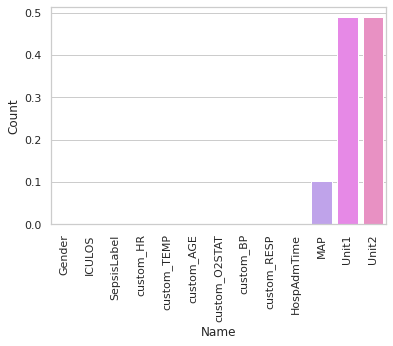

In [20]:
missing_values = Dataset.isnull().sum() / len(Dataset)
missing_values.sort_values(inplace=True)
missing_values

missing_values = missing_values.to_frame()
missing_values.columns = ['Count']
missing_values.index.names = ['Name']
missing_values['Name'] = missing_values.index


sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'Count', data=missing_values)
plt.xticks(rotation = 90)
plt.show()

### **Removing Missing Values Which Are Left Behind After Categorical Encoding**

In [0]:
Dataset=Dataset.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

### **Dependent & Undependent Variable**

In [22]:
X=Dataset.drop(columns='SepsisLabel')
y=Dataset['SepsisLabel']
y=pd.DataFrame(data=y)

X.head()
y.head()

,SepsisLabel
254,0
255,0
256,0
257,0
258,0


### **One Hot & Label Encoding**

In [23]:
labelencoder_X = LabelEncoder()
X.iloc[:, -1] = labelencoder_X.fit_transform(X.iloc[:, -1])
X.iloc[:, -2] = labelencoder_X.fit_transform(X.iloc[:, -2])
X.iloc[:, -3] = labelencoder_X.fit_transform(X.iloc[:, -3])
X.iloc[:, -4] = labelencoder_X.fit_transform(X.iloc[:, -4])
X.iloc[:, -5] = labelencoder_X.fit_transform(X.iloc[:, -5])
X.iloc[:, -6] = labelencoder_X.fit_transform(X.iloc[:, -6])

onehotencoder1 = OneHotEncoder(categories='auto',drop=[0])
custom_RESP = pd.DataFrame(onehotencoder1.fit_transform(X[['custom_RESP']]).toarray(),index=None)
custom_RESP=custom_RESP.rename(columns={0: "custom_RESP_0",1: "custom_RESP_1"})
print(custom_RESP.isnull().sum())

onehotencoder2 = OneHotEncoder(categories='auto',drop=[0])
custom_BP = pd.DataFrame(onehotencoder2.fit_transform(X[['custom_BP']]).toarray(),index=None)
custom_BP=custom_BP.rename(columns={0: "custom_BP_0",1: "custom_BP_1",2: "custom_BP_2",3: "custom_BP_3"})
print(custom_BP.isnull().sum())

onehotencoder3 = OneHotEncoder(categories='auto',drop=[0])
custom_O2STAT = pd.DataFrame(onehotencoder3.fit_transform(X[['custom_O2STAT']]).toarray(),index=None)
custom_O2STAT=custom_O2STAT.rename(columns={0: "custom_O2STAT_0",1: "custom_O2STAT_1"})
print(custom_O2STAT.isnull().sum())

onehotencoder4 = OneHotEncoder(categories='auto',drop=[0])
custom_AGE = pd.DataFrame(onehotencoder4.fit_transform(X[['custom_AGE']]).toarray(),index=None)
custom_AGE=custom_AGE.rename(columns={0: "custom_AGE_0"})
print(custom_AGE.isnull().sum())

onehotencoder5 = OneHotEncoder(categories='auto',drop=[0])
custom_TEMP = pd.DataFrame(onehotencoder5.fit_transform(X[['custom_TEMP']]).toarray(),index=None)
custom_TEMP=custom_TEMP.rename(columns={0: "custom_TEMP_0",1: "custom_TEMP_1"})
print(custom_TEMP.isnull().sum())

onehotencoder6 = OneHotEncoder(categories='auto',drop=[0])
custom_HR = pd.DataFrame(onehotencoder6.fit_transform(X[['custom_HR']]).toarray(),index=None)
custom_HR=custom_HR.rename(columns={0: "custom_HR_0",1: "custom_HR_1"})
print(custom_HR.isnull().sum())

X=X.drop(columns='custom_RESP')
X=X.drop(columns='custom_BP')
X=X.drop(columns='custom_O2STAT')
X=X.drop(columns='custom_AGE')
X=X.drop(columns='custom_TEMP')
X=X.drop(columns='custom_HR')
print(X.isnull().sum())


X=X.reset_index() #Reseting Index For Joing Below Dataframes 

X=X.join(custom_RESP)
X=X.join(custom_BP)
X=X.join(custom_O2STAT)
X=X.join(custom_AGE)
X=X.join(custom_TEMP)
X=X.join(custom_HR)

custom_RESP_0    0
custom_RESP_1    0
dtype: int64
custom_BP_0    0
custom_BP_1    0
custom_BP_2    0
custom_BP_3    0
dtype: int64
custom_O2STAT_0    0
custom_O2STAT_1    0
dtype: int64
custom_AGE_0    0
dtype: int64
custom_TEMP_0    0
custom_TEMP_1    0
dtype: int64
custom_HR_0    0
custom_HR_1    0
dtype: int64
MAP            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
dtype: int64


### **Train & Test Splitting**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### **SVM Classifier**

In [27]:
svm_Clf = svm.SVC()
svm_Clf.fit(X_train, y_train)
y_pred=svm_Clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


> **Confusion Matrix**



In [28]:
confusion_matrix(y_test, y_pred)

array([[71660,     0],
       [ 1420,     0]])

> **Accuracy Score**




In [29]:
accuracy_score(y_test, y_pred)

0.9805692391899289

### **Decision Tree Classifier**

In [0]:
dt_clf= DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)
y_predDT=dt_clf.predict(X_test)

> **Confusion Matrix**



In [31]:
confusion_matrix(y_test, y_predDT)

array([[71154,   506],
       [  445,   975]])

> **Accuracy Score**




In [32]:
accuracy_score(y_test, y_predDT)

0.9869868637110016